In [4]:
import load_files as lf
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import measurement_analysis as ma
import pickle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [5]:
file_path = "/Users/blazejmanczak/Desktop/Q1/DataChallenge3/"
flow_data_DRU, level_data_DRU = lf.get_measurements(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150")
rain_data = lf.get_rain(file_path +"/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries")
data = lf.sdf(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp")

In [3]:
# Either run this cell or open pickle in the next one
"""
df = ma.measurement_analysis(flow_data_DRU, level_data_DRU, rain_data, area_data=data.area_data,
                             village_code="DRU", dry_threshold = 0)
"""

In [ ]:
"""
#Save pickle
filename = 'ma_df_all'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()
"""

# open pickle
pickle_in = open("/Users/blazejmanczak/Desktop/Q1/DataChallenge3/ma_df_all", "rb")
df = pickle.load(pickle_in)

In [6]:
def summarize_rain_data(rain_data, area_data=None, village_code=None, dry_threshold=2.5):
    """
    Function to reshape rain data to be fit for the DWAAS analysis.

    ~~~~~ INPUT  ~~~~~
    rain_data:     File as gathered by load_files.get_rain(...)
    area_data:     File as gathered by load_files.sdf(...).area_data
    village_code:  Identifier of the pump (e.g. 'DRU' for Drunen)
    dry_threshold: Minimum average rain per hour in the area that counts as wet
                   (2.5 recommended)

    ~~~~~ OUTPUT ~~~~~
    A data frame with the columns
    Date :     Date of measurement
    Total:     Average rainfall measurement in the area (unweighted by area size)
    DrySeries: Number of days since last rainfall.
    """

    # Convert to datetime if necessary
    if rain_data["Start"].dtype != "<M8[ns]":
            rain_data["Start"] = pd.to_datetime(rain_data["Start"])

    # Sort data by time because of it being possibly unordered
    rain_data.sort_values("Start", inplace=True)
    rain_data.reset_index(drop=True, inplace=True)

    # Selects only data from certain right village_code
    if village_code is not None:
        area_data["village_ID"] = area_data["sewer_system"].str.slice(4,7)
        area_data = area_data.loc[area_data["village_ID"] == village_code]
        areas = area_data["area_name"][area_data["area_name"].apply(lambda i: i in rain_data.columns)].to_list()

        rain_data = rain_data.loc[:, ["Start", "End"] + areas]

    # Create date column and sum up rain measurements over all area
    rain_data["Date"] = rain_data["Start"].apply(lambda i: i.date())
    rain_data["Total"] = rain_data.iloc[:, 2:].mean(axis=1)

    # Sum measurements by date and create dry-series column
    #rain_data = rain_data.groupby("Date")["Total"].sum().reset_index(drop=False)
    #rain_data["DrySeries"] = reset_cumsum(rain_data["Total"], dry_threshold)

    return rain_data

rain_data_DRU = summarize_rain_data(rain_data, area_data= df.area_data,
                                    village_code="DRU", dry_threshold=2.5)[['Start', 'End', 'Total']]

In [8]:
level_data_DRU, flow_data_DRU = df.level_data, df.flow_data

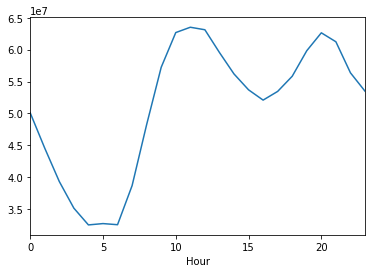

In [13]:
a = flow_data_DRU.groupby('Hour').aggregate(['sum', 'mean'])['Value']
a['sum'].plot()

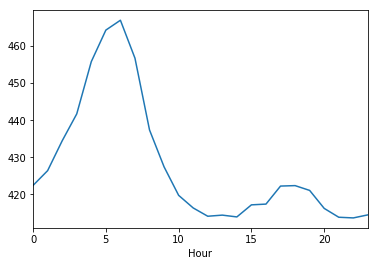

In [14]:
a['mean'].plot()

In [127]:
def take_subset(start_date, end_date, rain = rain_data_DRU, level = level_data_DRU, flow = flow_data_DRU):
    rain = rain.copy()
    level = level.copy()
    flow = flow.copy()
    
    rain = rain[(rain['Start'] > start_date) & (rain['Start'] < end_date)]
    level = level[(level['TimeStamp'] > start_date) & (level['TimeStamp'] < end_date)]
    flow = flow[(flow['TimeStamp'] > start_date) & (flow['TimeStamp'] < end_date)]
    
    return rain, level, flow 
 
#rain, level, flow = take_subset('2018-05-22 23:17:00','2018-05-23 04:30:01')
rain, level, flow = take_subset('2019-12-07 09:20:00','2019-12-07 09:22:00')

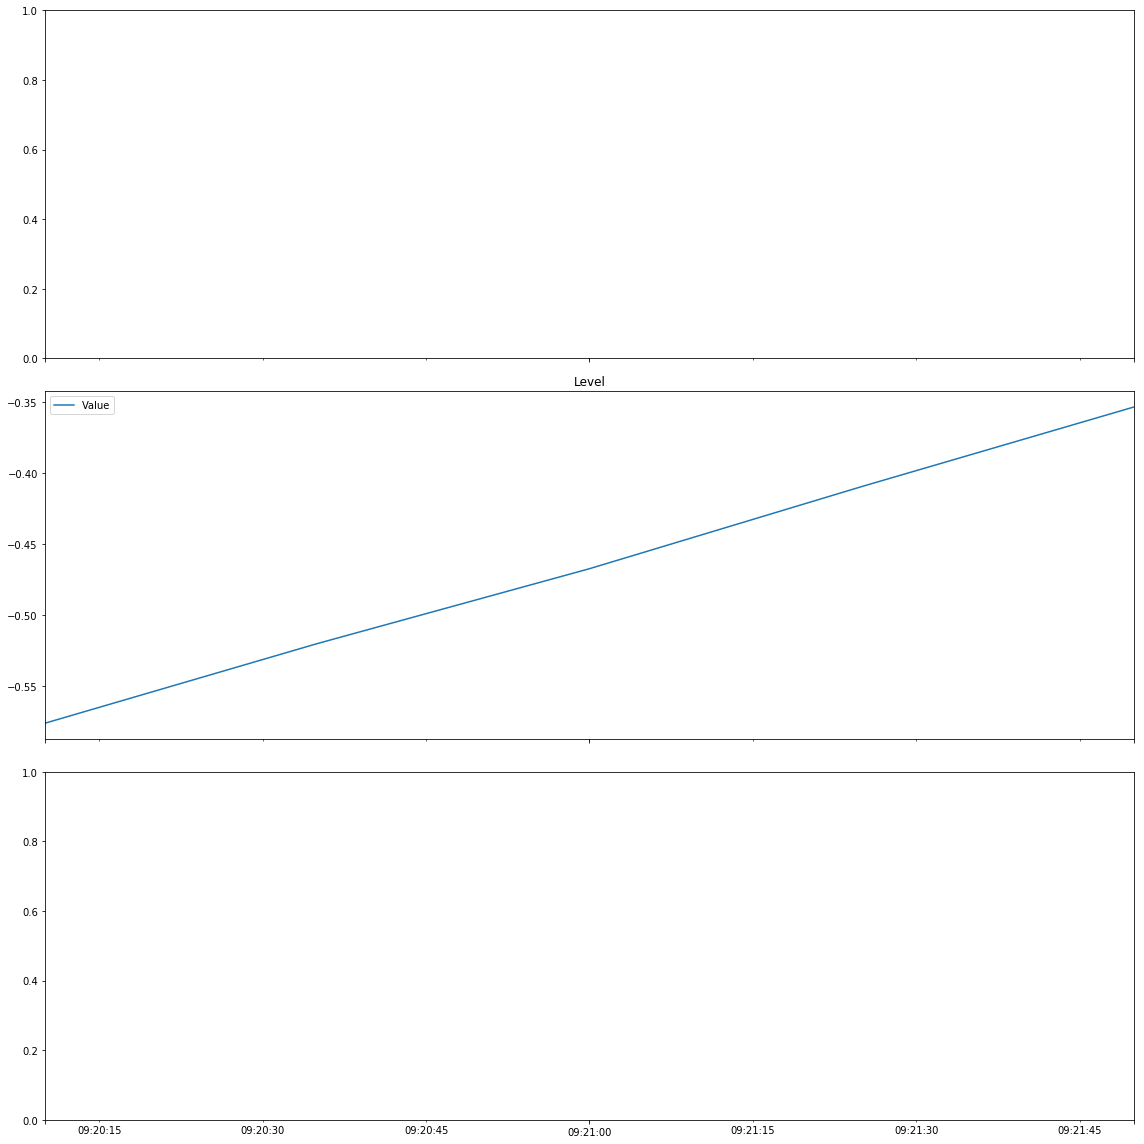

In [128]:
fig, ax = plt.subplots(nrows = 3, ncols=1, sharex = True, figsize = (16,16))

#ax[0] = rain.plot(x = 'Start', y = 'Total', figsize = (16,16), ax = ax[0])
ax[1] = level.plot(x = 'TimeStamp', y = 'Value', ax = ax[1])
#ax[2] = flow.plot(x = 'TimeStamp', y = 'Value', ax = ax[2])

#ax[0].set_title("Rain")
ax[1].set_title("Level")
#ax[2].set_title("Flow")
plt.tight_layout()

In [108]:
level_data_DRU['Value'].describe()

count    884203.000000
mean         -0.797148
std           0.381277
min          -1.811214
25%          -1.103166
50%          -0.783741
75%          -0.483211
max           2.175049
Name: Value, dtype: float64

In [75]:
np.quantile(level_data_DRU['Value'], q = 0.95)

-0.2394851